# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Peach/train",
    label_mode="categorical",
    class_names=['Peach___Bacterial_spot','Peach___healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Peach/valid",
    label_mode="categorical",
    class_names=['Peach___Bacterial_spot','Peach___healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 3566 files belonging to 2 classes.
==========================Validation Data====================
Found 891 files belonging to 2 classes.


In [5]:
# All images will be rescaled by 1./255. and Augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Peach/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Peach/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 3566 images belonging to 2 classes.
Found 891 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Wed May 31 16:54:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P0               39W /  N/A|   4337MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## MobileNetV2 Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Peach_MobileNetV2_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,586,434
Trainable params: 2,552,322
Non-

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.3246 - accuracy: 0.9588
Epoch 1: val_accuracy improved from -inf to 0.48934, saving model to Peach_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


179/179 [==============================] - 48s 232ms/step - loss: 0.3246 - accuracy: 0.9588 - val_loss: 11.0106 - val_accuracy: 0.4893 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9877
Epoch 2: val_accuracy improved from 0.48934 to 0.67677, saving model to Peach_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


179/179 [==============================] - 42s 232ms/step - loss: 0.0504 - accuracy: 0.9877 - val_loss: 2.9198 - val_accuracy: 0.6768 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9888
Epoch 3: val_accuracy improved from 0.67677 to 0.78451, saving model to Peach_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


179/179 [==============================] - 42s 234ms/step - loss: 0.0392 - accuracy: 0.9888 - val_loss: 1.1177 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 4/100
179/179 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9846
Epoch 4: val_accuracy improved from 0.78451 to 0.80247, saving model to Peach_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


179/179 [==============================] - 43s 241ms/step - loss: 0.0516 - accuracy: 0.9846 - val_loss: 1.1217 - val_accuracy: 0.8025 - lr: 0.0010
Epoch 5/100
179/179 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9899
Epoch 5: val_accuracy improved from 0.80247 to 0.91582, saving model to Peach_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


179/179 [==============================] - 44s 243ms/step - loss: 0.0342 - accuracy: 0.9899 - val_loss: 0.5934 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 6/100
179/179 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9930
Epoch 6: val_accuracy did not improve from 0.91582
179/179 [==============================] - 27s 150ms/step - loss: 0.0258 - accuracy: 0.9930 - val_loss: 1.4614 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 7/100
179/179 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9907
Epoch 7: val_accuracy improved from 0.91582 to 0.98092, saving model to Peach_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


179/179 [==============================] - 43s 238ms/step - loss: 0.0351 - accuracy: 0.9907 - val_loss: 0.0881 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 8/100
179/179 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9919
Epoch 8: val_accuracy improved from 0.98092 to 0.99551, saving model to Peach_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


179/179 [==============================] - 43s 240ms/step - loss: 0.0290 - accuracy: 0.9919 - val_loss: 0.0155 - val_accuracy: 0.9955 - lr: 0.0010
Epoch 9/100
179/179 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9938
Epoch 9: val_accuracy did not improve from 0.99551
179/179 [==============================] - 28s 154ms/step - loss: 0.0166 - accuracy: 0.9938 - val_loss: 0.0374 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 10/100
179/179 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9907
Epoch 10: val_accuracy did not improve from 0.99551
179/179 [==============================] - 28s 155ms/step - loss: 0.0292 - accuracy: 0.9907 - val_loss: 0.0303 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 11/100
179/179 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9944
Epoch 11: val_accuracy did not improve from 0.99551
179/179 [==============================] - 29s 159ms/step - loss: 0.0161 - accuracy: 0.9944 - val_loss: 0.0317 

INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model1_Based_Augmented\assets


179/179 [==============================] - 45s 249ms/step - loss: 0.0154 - accuracy: 0.9961 - val_loss: 0.0020 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 14/100
179/179 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9975
Epoch 14: val_accuracy did not improve from 1.00000
179/179 [==============================] - 27s 150ms/step - loss: 0.0104 - accuracy: 0.9975 - val_loss: 0.0934 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 15/100
179/179 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9921
Epoch 15: val_accuracy did not improve from 1.00000
179/179 [==============================] - 27s 152ms/step - loss: 0.0324 - accuracy: 0.9921 - val_loss: 0.0020 - val_accuracy: 0.9989 - lr: 0.0010
Epoch 16/100
179/179 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9941
Epoch 16: val_accuracy did not improve from 1.00000
179/179 [==============================] - 27s 149ms/step - loss: 0.0210 - accuracy: 0.9941 - val_loss: 0.015

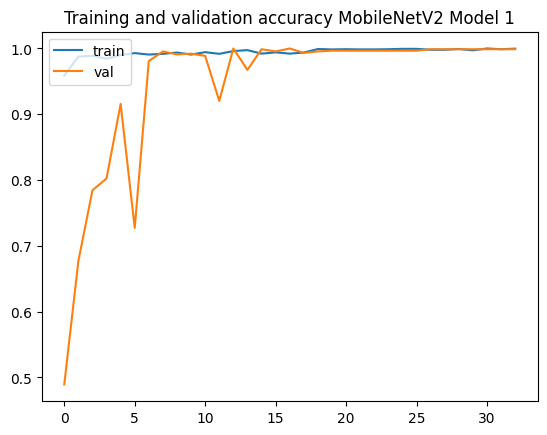

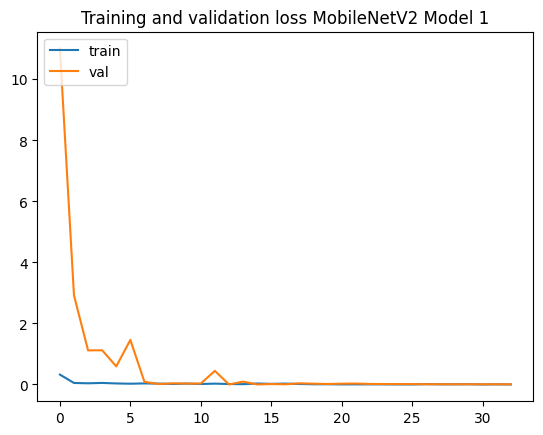

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

## MobileNetV2 Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Peach_MobileNetV2_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,586,434
Trainable params: 2,552,322
No

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9706
Epoch 1: val_accuracy improved from -inf to 0.52189, saving model to Peach_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


179/179 [==============================] - 47s 244ms/step - loss: 0.0898 - accuracy: 0.9706 - val_loss: 3.2855 - val_accuracy: 0.5219 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9837
Epoch 2: val_accuracy improved from 0.52189 to 0.93603, saving model to Peach_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


179/179 [==============================] - 43s 240ms/step - loss: 0.0584 - accuracy: 0.9837 - val_loss: 0.2003 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9832
Epoch 3: val_accuracy did not improve from 0.93603
179/179 [==============================] - 28s 156ms/step - loss: 0.0724 - accuracy: 0.9832 - val_loss: 18.1979 - val_accuracy: 0.4848 - lr: 0.0010
Epoch 4/100
179/179 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9854
Epoch 4: val_accuracy did not improve from 0.93603
179/179 [==============================] - 28s 156ms/step - loss: 0.0521 - accuracy: 0.9854 - val_loss: 0.6695 - val_accuracy: 0.6723 - lr: 0.0010
Epoch 5/100
179/179 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.9851
Epoch 5: val_accuracy did not improve from 0.93603
179/179 [==============================] - 29s 162ms/step - loss: 0.0446 - accuracy: 0.9851 - val_loss: 18.7834 - 

INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


179/179 [==============================] - 44s 246ms/step - loss: 0.0143 - accuracy: 0.9966 - val_loss: 0.3274 - val_accuracy: 0.9719 - lr: 1.0000e-04
Epoch 9/100
179/179 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9955
Epoch 9: val_accuracy improved from 0.97194 to 0.98878, saving model to Peach_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


179/179 [==============================] - 44s 245ms/step - loss: 0.0116 - accuracy: 0.9955 - val_loss: 0.0890 - val_accuracy: 0.9888 - lr: 1.0000e-04
Epoch 10/100
179/179 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9978
Epoch 10: val_accuracy improved from 0.98878 to 0.99327, saving model to Peach_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


179/179 [==============================] - 44s 244ms/step - loss: 0.0083 - accuracy: 0.9978 - val_loss: 0.0400 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 11/100
179/179 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9992
Epoch 11: val_accuracy improved from 0.99327 to 0.99439, saving model to Peach_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


179/179 [==============================] - 44s 245ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0186 - val_accuracy: 0.9944 - lr: 1.0000e-04
Epoch 12/100
179/179 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9972
Epoch 12: val_accuracy improved from 0.99439 to 0.99776, saving model to Peach_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


179/179 [==============================] - 44s 246ms/step - loss: 0.0157 - accuracy: 0.9972 - val_loss: 0.0043 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 13/100
179/179 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9986
Epoch 13: val_accuracy improved from 0.99776 to 0.99888, saving model to Peach_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


179/179 [==============================] - 45s 248ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0024 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 14/100
179/179 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9994
Epoch 14: val_accuracy did not improve from 0.99888
179/179 [==============================] - 29s 159ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0046 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 15/100
179/179 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9986
Epoch 15: val_accuracy did not improve from 0.99888
179/179 [==============================] - 29s 159ms/step - loss: 0.0030 - accuracy: 0.9986 - val_loss: 0.0119 - val_accuracy: 0.9955 - lr: 1.0000e-04
Epoch 16/100
179/179 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9978
Epoch 16: val_accuracy did not improve from 0.99888
179/179 [==============================] - 28s 158ms/step - loss: 0.0052 - accuracy: 0.9978 - val

INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Peach_MobileNetV2_model2_Based_Augmented\assets


179/179 [==============================] - 44s 247ms/step - loss: 0.0031 - accuracy: 0.9986 - val_loss: 3.6869e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 18/100
179/179 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9997
Epoch 18: val_accuracy did not improve from 1.00000
179/179 [==============================] - 29s 161ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 3.1638e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19/100
179/179 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9980
Epoch 19: val_accuracy did not improve from 1.00000
179/179 [==============================] - 29s 160ms/step - loss: 0.0046 - accuracy: 0.9980 - val_loss: 0.0148 - val_accuracy: 0.9955 - lr: 1.0000e-04
Epoch 20/100
179/179 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9994
Epoch 20: val_accuracy did not improve from 1.00000
179/179 [==============================] - 29s 160ms/step - loss: 0.0013 - accuracy: 0.99

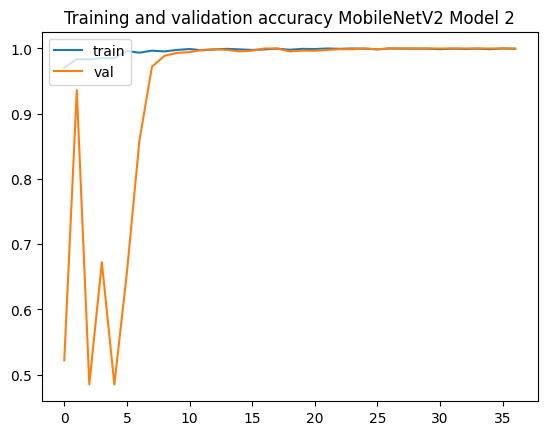

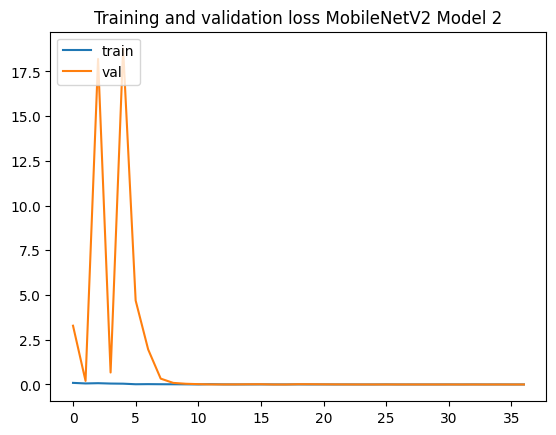

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')